In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
import networkx as nx

BASE_DIR = Path.cwd().resolve()
MONTHLY_PATH = BASE_DIR.parents[1] / "data" / "processed" / "train_monthly.csv"

monthly = pd.read_csv(MONTHLY_PATH)
print("monthly shape:", monthly.shape)
monthly.head()


monthly shape: (3734, 8)


,item_id,year,month,type,hs4,total_value,total_weight,total_quantity
0,AANGBULD,2022,1,1,4810,14276,17625.0,0.0
1,AANGBULD,2022,2,1,4810,52347,67983.0,0.0
2,AANGBULD,2022,3,1,4810,53549,69544.0,0.0
3,AANGBULD,2022,5,1,4810,26997,34173.0,0.0
4,AANGBULD,2022,6,1,4810,84489,103666.0,0.0


🔹 HS4 고유 개수: 71

📊 HS4별 행 개수 상위 10개


,hs4,count
0,2805,219
1,3824,193
2,2811,172
3,8501,142
4,8102,129
5,8505,129
6,2807,124
7,3815,111
8,3102,86
9,8714,86


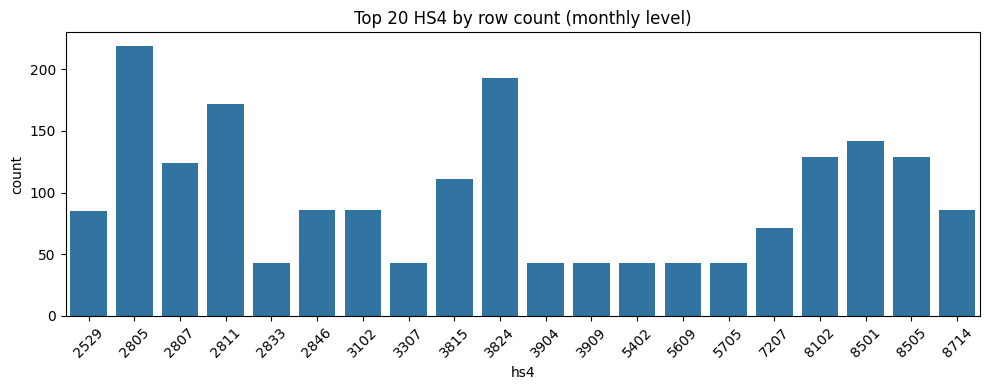

In [2]:
print("🔹 HS4 고유 개수:", monthly["hs4"].nunique())

hs4_counts = monthly["hs4"].value_counts().reset_index()
hs4_counts.columns = ["hs4", "count"]
print("\n📊 HS4별 행 개수 상위 10개")
display(hs4_counts.head(10))

plt.figure(figsize=(10, 4))
sns.barplot(data=hs4_counts.head(20), x="hs4", y="count")
plt.title("Top 20 HS4 by row count (monthly level)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


💰 HS4별 total_value 상위 10개


,hs4,total_value,total_weight,total_quantity
0,3824,4746549091,1.570919e+09,0.0
1,2814,2579886853,4.396803e+09,0.0
2,8505,1569530939,5.099168e+07,0.0
3,3102,1509013070,2.780464e+09,0.0
4,3815,1198067548,1.069971e+08,0.0
5,6211,1081997661,3.677135e+07,103520668.0
6,8501,920900932,5.700897e+07,28774.0
7,9403,740415787,2.592679e+08,0.0
8,2811,740139653,4.191746e+08,0.0
9,7207,446891870,7.644839e+08,0.0


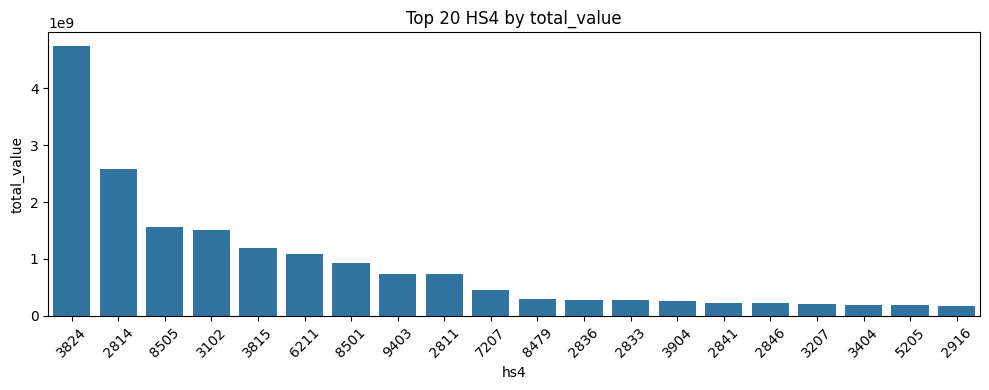


⚖️ HS4별 value_per_weight 상위 10개 (고가·저중량 후보)


,hs4,total_value,total_weight,total_quantity,value_per_weight
61,5119,307935,153.0,0.0,2012.647046
22,3006,97019745,83789.0,0.0,1157.905513
16,3207,212393025,260383.0,0.0,815.694669
57,9022,541289,2120.0,131.0,255.325000
29,3206,30688488,132742.0,0.0,231.188983
63,3813,196919,1199.0,0.0,164.236030
24,4202,83415636,525093.0,793640545.0,158.858785
32,6101,16693682,153556.0,1418976.0,108.713968
28,2805,37858095,392890.0,0.0,96.358001
21,8102,100283080,1123704.0,0.0,89.243324


In [26]:
hs4_value_stats = (
    monthly.groupby("hs4")[["total_value", "total_weight", "total_quantity"]]
    .sum()
    .sort_values("total_value", ascending=False)
    .reset_index()
)

print("💰 HS4별 total_value 상위 10개")
display(hs4_value_stats.head(10))

# 총 무역량 상위 20개 시각화
plt.figure(figsize=(10, 4))
sns.barplot(data=hs4_value_stats.head(20), x="hs4", y="total_value")
plt.title("Top 20 HS4 by total_value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# value / weight 비율 (고가/저가 품목군 감)
hs4_value_stats["value_per_weight"] = (
    hs4_value_stats["total_value"] / (hs4_value_stats["total_weight"] + 1e-6)
)

print("\n⚖️ HS4별 value_per_weight 상위 10개 (고가·저중량 후보)")
display(
    hs4_value_stats.sort_values("value_per_weight", ascending=False).head(10)
)


#화학·비료류 (38, 28, 31 계열), 기계·전자 부품 (85 계열), 소비재/완제품 (62 의류, 94 가구, 72 철강) - 원재료와 완제품 연결 주의
#무게가 크고 value가 적다: 원재료, 무게가 적고 value가 크다: 완제품
#원재료가 선행, 완제품이 후행 -- 다만, 이 중간과정인 부품형(중간재)를 어떻게 구별할 것인지가 관건

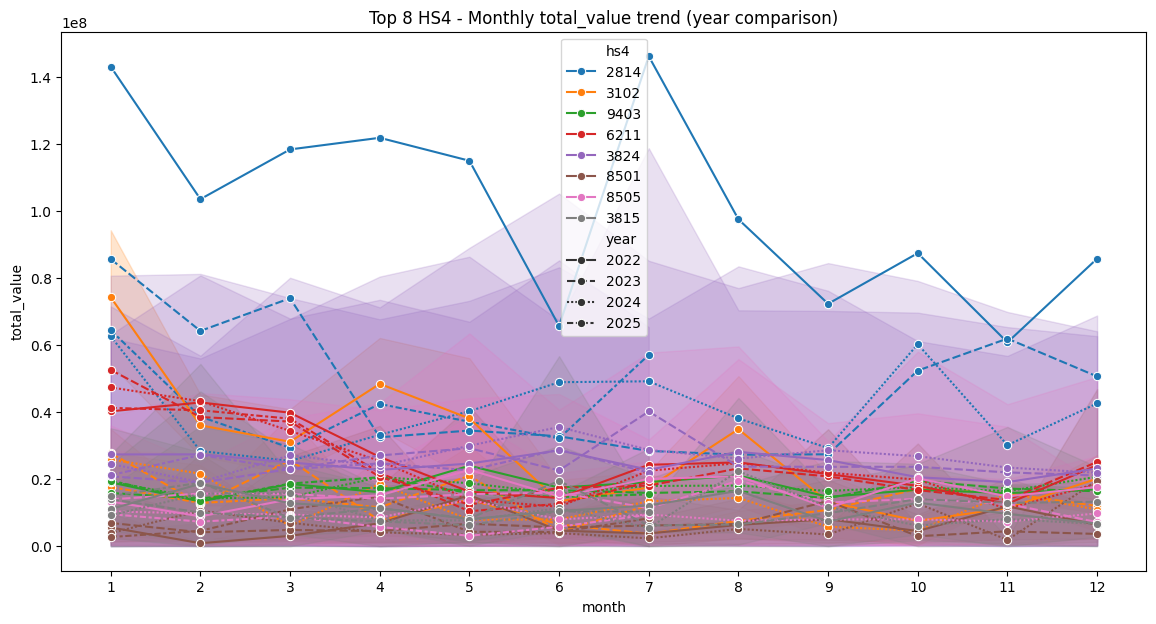

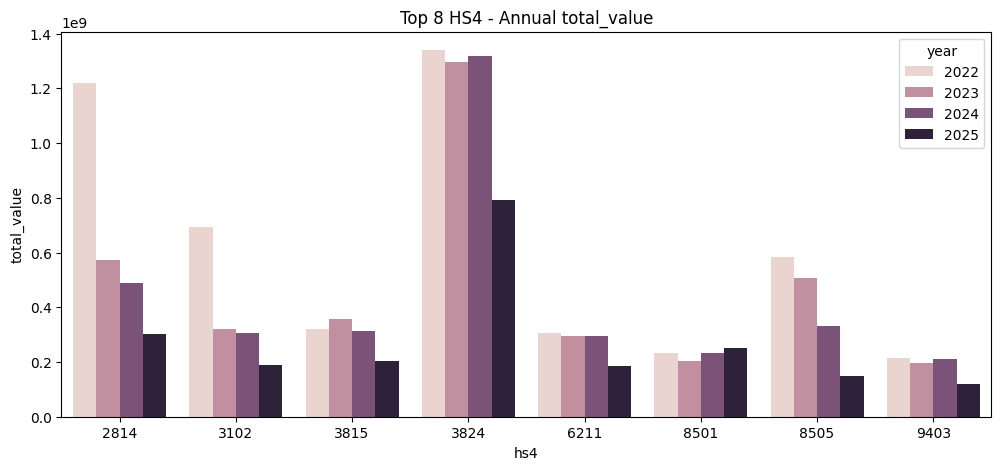

In [27]:
top8 = ["3824", "2814", "8505", "3102", "3815", "6211", "8501", "9403"]
sub8 = monthly[monthly["hs4"].isin(top8)].copy()

plt.figure(figsize=(14, 7))
sns.lineplot(data=sub8, x="month", y="total_value", hue="hs4", style="year", marker="o")
plt.title("Top 8 HS4 - Monthly total_value trend (year comparison)")
plt.xticks(range(1,13))
plt.show()

temp = sub8.groupby(["hs4", "year"])["total_value"].sum().reset_index()

plt.figure(figsize=(12, 5))
sns.barplot(data=temp, x="hs4", y="total_value", hue="year")
plt.title("Top 8 HS4 - Annual total_value")
plt.show()


분석 대상 HS4: [3824, 2814, 8505, 3102, 3815, 6211, 8501, 9403]


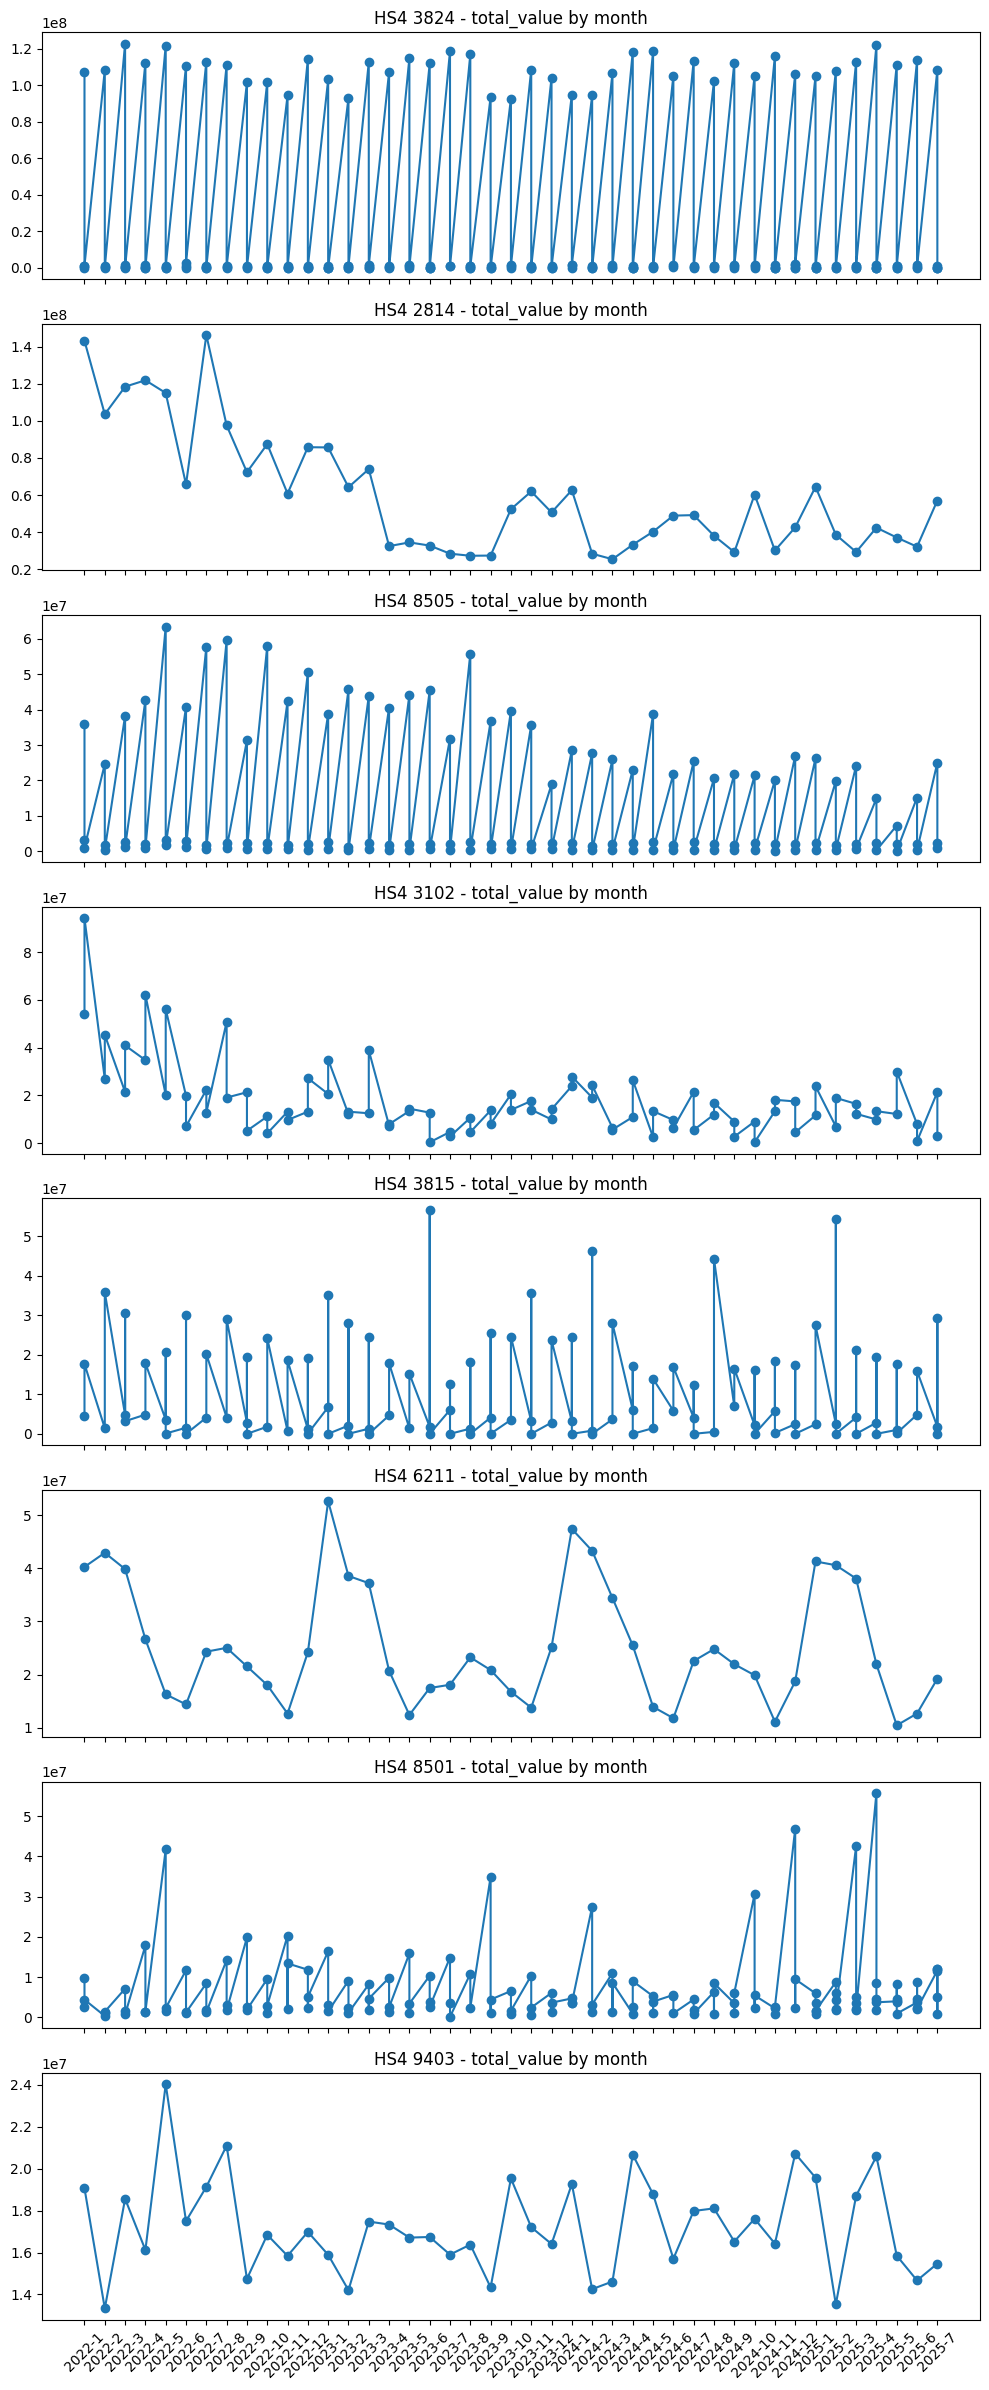

In [4]:
# 전체 중 total_value 상위 8개 HS4 선택
top_hs4 = hs4_value_stats.head(8)["hs4"].tolist()
print("분석 대상 HS4:", top_hs4)

# year-month 키 만들기
monthly["ym"] = monthly["year"].astype(str) + "-" + monthly["month"].astype(str)

fig, axes = plt.subplots(len(top_hs4), 1, figsize=(10, 3 * len(top_hs4)), sharex=True)

for i, h in enumerate(top_hs4):
    sub = monthly[monthly["hs4"] == h].sort_values(["year", "month"])
    axes[i].plot(sub["ym"], sub["total_value"], marker="o")
    axes[i].set_title(f"HS4 {h} - total_value by month")
    axes[i].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


In [33]:
#3824 & 8505 = 핵심 cycle cluster
#6211 & 9403 = final goods cluster
#3815 & 3102 = irregular upstream cluster
#2814 = long-term macro cluster
#8501 = project cluster
   ```
| HS4      | 패턴                  | 산업유형   | 예측 난이도 | leading     |
| -------- | ------------------- | ------ | ------ | ----------- |
| **3824** | 규칙적 batch           | 화학 중간재 | 쉬움     | 강           |
| **8505** | 규칙적 batch           | 전기 부품  | 쉬움     | 강           |
| **3815** | 불규칙 spike           | 화학 촉매  | 어려움    | 중           |
| **3102** | downtrend+spike     | 비료     | 어려움    | 약           |
| **2814** | downtrend           | 무기화학   | 쉬움     | macro-level |
| **6211** | 계절성                 | 의류     | 쉬움     | following   |
| **9403** | 안정                  | 가구     | 매우 쉬움  | following   |
| **8501** | irregular big spike | 설비     | 어려움    | 약           |
    ```


IndentationError: unexpected indent (375008178.py, line 6)

/tmp/ipykernel_133612/2475603215.py:14: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_133612/2475603215.py:14: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_133612/2475603215.py:14: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_133612/2475603215.py:14: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_133612/2475603215.py:14: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_133612/2475603215.py:14: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/data/ephemeral/home/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50900 (\N{HANGU

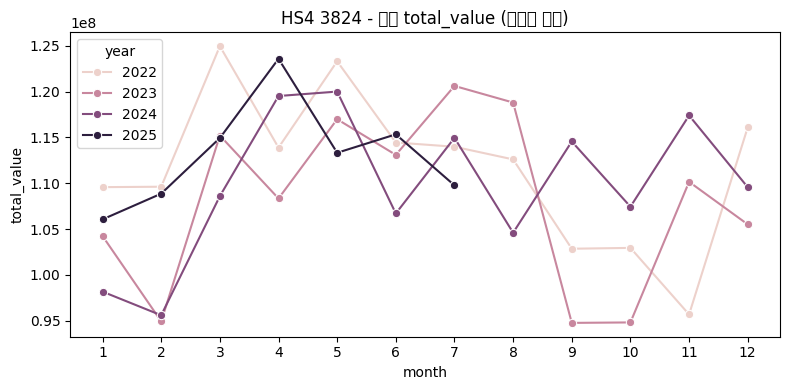

In [5]:
# 특정 hs4 연도별 라인
target_hs4 = top_hs4[0]  # 마음대로 바꿔도 됨

sub = (
    monthly[monthly["hs4"] == target_hs4]
    .groupby(["year", "month"], as_index=False)["total_value"]
    .sum()
)

plt.figure(figsize=(8, 4))
sns.lineplot(data=sub, x="month", y="total_value", hue="year", marker="o")
plt.title(f"HS4 {target_hs4} - 월별 total_value (연도별 비교)")
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()


📌 HS4별 item 다양성 & 규모


,hs4,total_value,total_weight,total_quantity,value_per_weight,n_item
0,3824,4746549091,1.570919e+09,0.0,3.021511,5
1,2814,2579886853,4.396803e+09,0.0,0.586764,1
2,8505,1569530939,5.099168e+07,0.0,30.780136,3
3,3102,1509013070,2.780464e+09,0.0,0.542720,2
4,3815,1198067548,1.069971e+08,0.0,11.197196,3
5,6211,1081997661,3.677135e+07,103520668.0,29.425016,1
6,8501,920900932,5.700897e+07,28774.0,16.153616,5
7,9403,740415787,2.592679e+08,0.0,2.855794,1
8,2811,740139653,4.191746e+08,0.0,1.765707,4
9,7207,446891870,7.644839e+08,0.0,0.584567,2


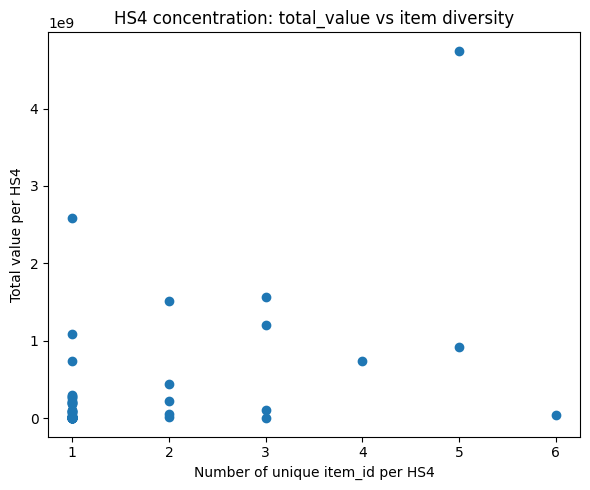

In [9]:
#hs4 별 item_id 다양성

# dtype 통일
hs4_value_stats["hs4"] = hs4_value_stats["hs4"].astype(str).str.zfill(4)
hs4_item_div["hs4"] = hs4_item_div["hs4"].astype(str).str.zfill(4)

# merge
hs4_profile = hs4_value_stats.merge(hs4_item_div, on="hs4", how="left")

# 원본 df 기준 (seq 전 구조화 전)
from pathlib import Path
RAW_TRAIN_PATH = BASE_DIR.parents[1] / "data" / "raw" / "train.csv"
raw_df = pd.read_csv(RAW_TRAIN_PATH)
raw_df["hs4"] = raw_df["hs4"].astype(str).str.zfill(4)

hs4_item_div = (
    raw_df.groupby("hs4")["item_id"]
    .nunique()
    .reset_index(name="n_item")
)

# total_value 합쳐서 하나의 테이블로
hs4_profile = hs4_value_stats.merge(hs4_item_div, on="hs4", how="left")

print("📌 HS4별 item 다양성 & 규모")
display(hs4_profile.head(10))

# total_value vs item 다양성 산점도
plt.figure(figsize=(6, 5))
plt.scatter(hs4_profile["n_item"], hs4_profile["total_value"])
plt.xlabel("Number of unique item_id per HS4")
plt.ylabel("Total value per HS4")
plt.title("HS4 concentration: total_value vs item diversity")
plt.tight_layout()
plt.show()


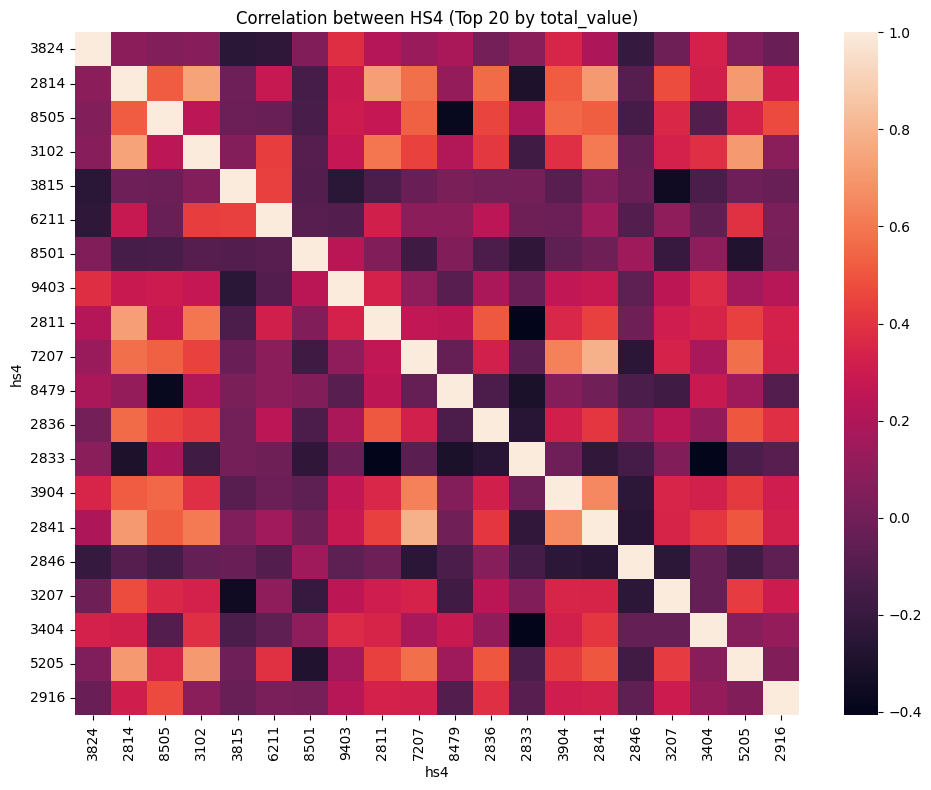

🔗 HS4 간 상관계수 상위 20쌍:


hs4   hs4 
2841  7207    0.787847
2814  3102    0.740576
2811  2814    0.720786
2814  5205    0.707539
3102  5205    0.705176
2814  2841    0.704341
2841  3904    0.649055
3904  7207    0.629595
2841  3102    0.605928
2811  3102    0.596010
5205  7207    0.573255
2814  7207    0.572361
      2836    0.564883
3904  8505    0.553767
7207  8505    0.531196
2841  8505    0.523359
2814  8505    0.520305
      3904    0.517955
2811  2836    0.510265
2836  5205    0.503092
dtype: float64

In [8]:
# year-month 기준으로 HS4 피벗 (value 기준)
pivot = (
    monthly.groupby(["year", "month", "hs4"])["total_value"]
    .sum()
    .reset_index()
)

pivot["ym"] = pivot["year"].astype(str) + "-" + pivot["month"].astype(str)
pivot_table = pivot.pivot(index="ym", columns="hs4", values="total_value").fillna(0)

# HS4가 너무 많으면 상위 N개만 사용 (여기선 total_value 상위 20개)
top20 = hs4_value_stats.head(20)["hs4"].tolist()
pivot_top = pivot_table[top20]

corr = pivot_top.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False)
plt.title("Correlation between HS4 (Top 20 by total_value)")
plt.tight_layout()
plt.show()

# 코리레이션 상위 쌍 출력
corr_unstack = corr.unstack()
corr_unstack = corr_unstack[corr_unstack.index.get_level_values(0) < corr_unstack.index.get_level_values(1)]
top_pairs = corr_unstack.sort_values(ascending=False).head(20)

print("🔗 HS4 간 상관계수 상위 20쌍:")
display(top_pairs)


In [10]:
# 대분류 비교

In [14]:
raw_df["hs4"] = raw_df["hs4"].astype(str).str.zfill(4)
monthly["hs4"] = monthly["hs4"].astype(str).str.zfill(4)

raw_df["hs2"] = raw_df["hs4"].str[:2]
monthly["hs2"] = monthly["hs4"].str[:2]


/data/ephemeral/home/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


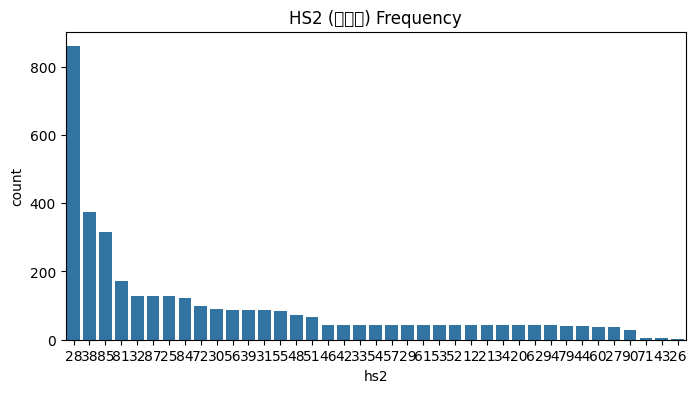

In [15]:
hs2_counts = monthly["hs2"].value_counts().reset_index()
hs2_counts.columns = ["hs2", "count"]

plt.figure(figsize=(8,4))
sns.barplot(data=hs2_counts, x="hs2", y="count")
plt.title("HS2 (대분류) Frequency")
plt.show()


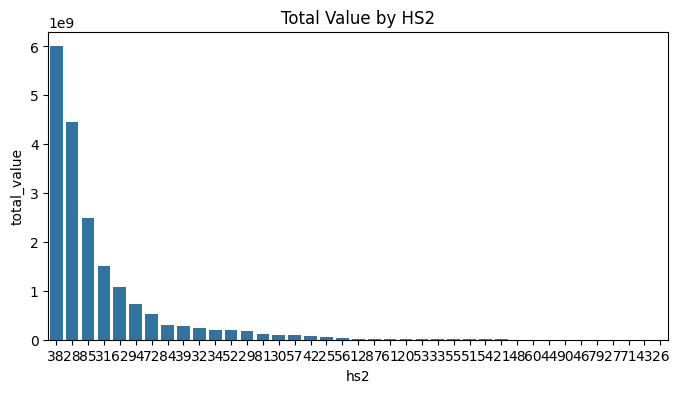

In [16]:
hs2_value = (
    monthly.groupby("hs2")["total_value"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(8,4))
sns.barplot(data=hs2_value, x="hs2", y="total_value")
plt.title("Total Value by HS2")
plt.show()


/data/ephemeral/home/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/data/ephemeral/home/py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


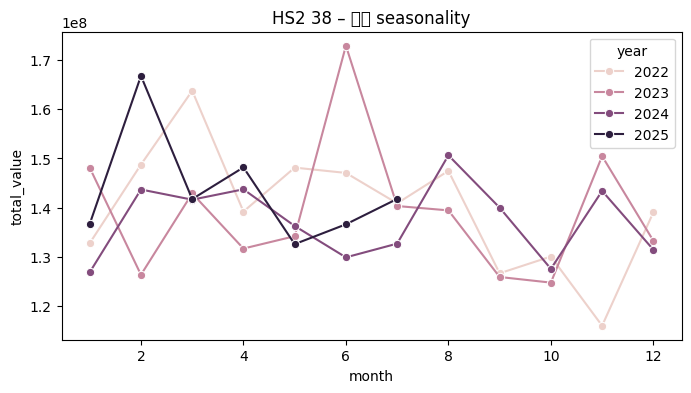

In [17]:
hs2_monthly = (
    monthly.groupby(["hs2", "year", "month"])["total_value"]
    .sum()
    .reset_index()
)

target_hs2 = hs2_value["hs2"].iloc[0]  # top 1 HS2
temp = hs2_monthly[hs2_monthly["hs2"] == target_hs2]

plt.figure(figsize=(8,4))
sns.lineplot(data=temp, x="month", y="total_value", hue="year", marker="o")
plt.title(f"HS2 {target_hs2} – 월별 seasonality")
plt.show()


In [18]:
mapping = (
    monthly.groupby(["hs2", "hs4"])["total_value"]
    .sum()
    .reset_index()
)

print("HS2 → HS4 계층 구조 예시:")
display(mapping.head())


HS2 → HS4 계층 구조 예시:


,hs2,hs4,total_value
0,12,1210,19055741
1,20,2002,16637315
2,21,2102,5453639
3,25,2501,6407142
4,25,2529,56095134


In [19]:
hs2_hs4_count = (
    monthly.groupby("hs2")["hs4"].nunique()
    .reset_index(name="n_hs4")
    .sort_values("n_hs4", ascending=False)
)
display(hs2_hs4_count)

,hs2,n_hs4
6,28,10
8,30,4
13,38,4
35,85,3
34,84,3
10,32,3
19,48,2
24,55,2
20,51,2
17,44,2


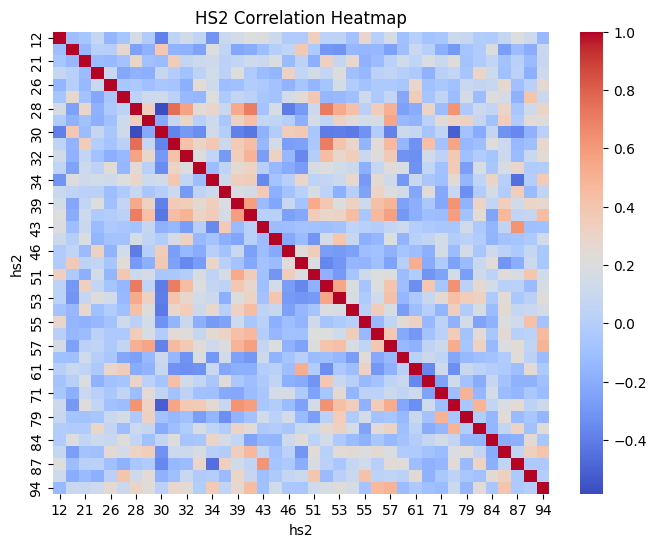

In [20]:
pivot_hs2 = (
    monthly.groupby(["year", "month", "hs2"])["total_value"]
    .sum()
    .reset_index()
)

pivot_hs2["ym"] = pivot_hs2["year"].astype(str)+"-"+pivot_hs2["month"].astype(str)
pt = pivot_hs2.pivot(index="ym", columns="hs2", values="total_value").fillna(0)

corr_hs2 = pt.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_hs2, cmap="coolwarm", annot=False)
plt.title("HS2 Correlation Heatmap")
plt.show()


In [45]:
# ============================================================
# HS2 Feature Engineering
# ============================================================
monthly = pd.read_csv(MONTHLY_PATH)

monthly["hs2"] = monthly["hs4"].astype(str).str[:2]

# 2) HS2별 total_value 합계
hs2_value = (
    monthly.groupby("hs2")["total_value"]
    .sum()
    .reset_index(name="hs2_total_value")
)

# 전체 총 value
total_value_sum = hs2_value["hs2_total_value"].sum()

# 3) HS2별 전체 대비 비중
hs2_value["hs2_share_of_total"] = hs2_value["hs2_total_value"] / total_value_sum

# 4) HS2 value rank (내림차순)
hs2_value["hs2_value_rank"] = hs2_value["hs2_total_value"].rank(
    method="dense", ascending=False
).astype(int)

# 5) HS2 내 HS4 개수
hs2_hs4_count = (
    monthly.groupby("hs2")["hs4"]
    .nunique()
    .reset_index(name="hs2_n_hs4")
)

# 6) HS2 내 item_id 개수
hs2_item_count = (
    raw_df.groupby("hs2")["item_id"]
    .nunique()
    .reset_index(name="hs2_n_item")
)

# 7) 모든 HS2 feature merge
hs2_features = (
    hs2_value
    .merge(hs2_hs4_count, on="hs2", how="left")
    .merge(hs2_item_count, on="hs2", how="left")
)

print("🎉 HS2 Feature Frame 생성 완료!")
display(hs2_features.head())

# 8) monthly에 다시 merge해 넣기
monthly = monthly.merge(hs2_features, on="hs2", how="left")

print("📌 monthly에 HS2 피처 추가 완료:", monthly.shape)
display(monthly.head())


🎉 HS2 Feature Frame 생성 완료!


,hs2,hs2_total_value,hs2_share_of_total,hs2_value_rank,hs2_n_hs4,hs2_n_item
0,12,19055741,1.011020e-03,20,1,1
1,20,16637315,8.827085e-04,23,1,1
2,21,5453639,2.893480e-04,29,1,1
3,25,62502276,3.316117e-03,18,2,3
4,26,228,1.209676e-08,39,1,1


📌 monthly에 HS2 피처 추가 완료: (3734, 14)


,item_id,year,month,type,hs4,total_value,total_weight,total_quantity,hs2,hs2_total_value,hs2_share_of_total,hs2_value_rank,hs2_n_hs4,hs2_n_item
0,AANGBULD,2022,1,1,4810,14276,17625.0,0.0,48,4098439,0.000217,30,2,2
1,AANGBULD,2022,2,1,4810,52347,67983.0,0.0,48,4098439,0.000217,30,2,2
2,AANGBULD,2022,3,1,4810,53549,69544.0,0.0,48,4098439,0.000217,30,2,2
3,AANGBULD,2022,5,1,4810,26997,34173.0,0.0,48,4098439,0.000217,30,2,2
4,AANGBULD,2022,6,1,4810,84489,103666.0,0.0,48,4098439,0.000217,30,2,2


In [36]:
# --------------------------------------------------------------
# 1) 월별 pivot 생성 (ym 기준 index, hs4가 column)
# --------------------------------------------------------------
monthly = pd.read_csv(MONTHLY_PATH)

# year-month 문자열 생성
monthly["ym"] = monthly["year"].astype(str) + "-" + monthly["month"].astype(str)

pivot = monthly.pivot_table(
    index="ym",
    columns="hs4",
    values="total_value",
    aggfunc="sum"
).fillna(0)

pivot = pivot.sort_index()   # 시계열 정렬

# --------------------------------------------------------------
# 2) lag correlation 계산 함수
# --------------------------------------------------------------
def lag_corr(df, lag=1):
    cols = df.columns
    results = []

    for a in cols:
        for b in cols:
            if a == b:
                continue
            # a(t-lag) vs b(t)
            x = df[a].shift(lag)
            y = df[b]

            corr = np.corrcoef(x.iloc[lag:], y.iloc[lag:])[0, 1]
            results.append([a, b, lag, corr])

    return pd.DataFrame(results, columns=["lead_hs4", "follow_hs4", "lag", "corr"])


# --------------------------------------------------------------
# 3) lag=1~6 전체 계산
# --------------------------------------------------------------
lag_all = []
for L in range(1, 7):
    lag_df = lag_corr(pivot, lag=L)
    lag_all.append(lag_df)

lag_corr_df = pd.concat(lag_all, axis=0)
lag_corr_df = lag_corr_df.sort_values("corr", ascending=False)

# --------------------------------------------------------------
# 4) 상위 30개 출력
# --------------------------------------------------------------
print("\n🔥 Lag correlation 상위 30개 (lag=1~6 통합)\n")
print(lag_corr_df.head(30))


/data/ephemeral/home/py310/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/data/ephemeral/home/py310/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]



🔥 Lag correlation 상위 30개 (lag=1~6 통합)

      lead_hs4  follow_hs4  lag      corr
2105      3813        2612    2  0.945947
2550      4302        3813    5  0.894613
4837      9022        2710    3  0.860852
2574      4302        7142    6  0.817126
1084      2841        4202    2  0.808879
2681      4408        3024    4  0.807421
1084      2841        4202    1  0.807256
2667      4408        2710    6  0.784025
3019      5119        2807    2  0.769482
580       2805        3024    6  0.767782
597       2805        4408    2  0.741288
698       2807        9022    6  0.738473
784       2814        2841    1  0.737506
4795      8714        4202    2  0.731570
2465      4202        2841    1  0.729538
636       2807        2701    6  0.728149
1061      2841        2814    1  0.725337
4797      8714        4403    2  0.716769
2494      4202        5309    6  0.716647
4595      8505        5309    6  0.714340
110       2002        4810    1  0.708694
3214      5309        8505    4  0.7

In [39]:
# pivot column을 문자열로 변환
pivot.columns = pivot.columns.astype(str)

# 우리가 분석할 상위 8개 HS4
top8 = ["3824","2814","8505","3102","3815","6211","8501","9403"]

pivot8 = pivot[top8]

# lag correlation 다시 계산
lag_all = []
for L in range(1, 7):
    lag_df = lag_corr(pivot8, lag=L)
    lag_all.append(lag_df)

lag_corr_top8 = pd.concat(lag_all).sort_values("corr", ascending=False)
print(lag_corr_top8.head(30))


   lead_hs4 follow_hs4  lag      corr
8      2814       8505    3  0.577455
23     3102       8505    3  0.566971
8      2814       8505    1  0.542597
9      2814       3102    1  0.522155
9      2814       3102    3  0.504456
8      2814       8505    2  0.503570
8      2814       8505    6  0.502741
22     3102       2814    5  0.490866
22     3102       2814    6  0.488697
8      2814       8505    5  0.479098
22     3102       2814    3  0.473821
15     8505       2814    2  0.471051
9      2814       3102    6  0.470394
22     3102       2814    1  0.444734
8      2814       8505    4  0.444054
15     8505       2814    3  0.436913
22     3102       2814    4  0.403235
9      2814       3102    4  0.395351
15     8505       2814    4  0.389252
22     3102       2814    2  0.382809
23     3102       8505    1  0.380978
9      2814       3102    5  0.379744
9      2814       3102    2  0.358485
16     8505       3102    3  0.351394
16     8505       3102    5  0.345355
27     3102 

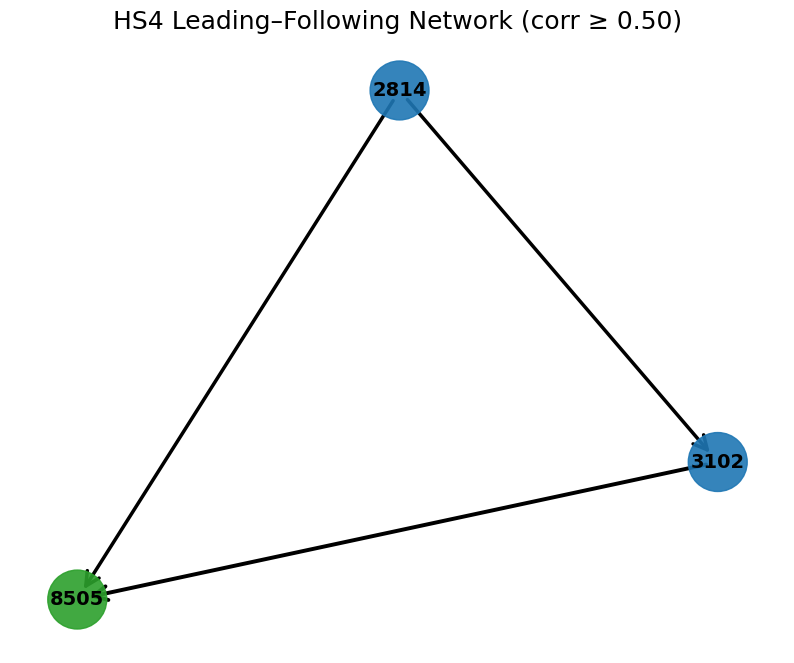

In [41]:

# -------------------------
# 1) strong edges만 필터링
# -------------------------
df = lag_corr_top8.copy()
strong = df[df["corr"] >= 0.50]   # 강한 신호만

# -------------------------
# 2) Graph 객체 생성
# -------------------------
G = nx.DiGraph()

# cluster mapping (대장 표 기준)
hs4_cluster = {
    "2814": "raw",
    "3102": "raw",
    "2811": "raw",
    "7207": "raw",
    "3824": "chem_mid",
    "3815": "chem_mid",
    "8505": "parts",
    "8501": "parts",
    "6211": "final",
    "9403": "final"
}

cluster_color_map = {
    "raw": "#1f77b4",
    "chem_mid": "#ff7f0e",
    "parts": "#2ca02c",
    "final": "#d62728"
}

# -------------------------
# 3) 노드 추가 (색상 포함)
# -------------------------
for hs4 in strong["lead_hs4"].unique():
    G.add_node(hs4, color=cluster_color_map[hs4_cluster[hs4]])

for hs4 in strong["follow_hs4"].unique():
    G.add_node(hs4, color=cluster_color_map[hs4_cluster[hs4]])

# -------------------------
# 4) 엣지 추가 (굵기 = corr)
# -------------------------
for _, row in strong.iterrows():
    G.add_edge(
        row["lead_hs4"],
        row["follow_hs4"],
        weight=row["corr"]
    )

# -------------------------
# 5) 레이아웃 & 그리기
# -------------------------
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(10, 8))

# 노드 그리기
node_colors = [G.nodes[n]["color"] for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1800, alpha=0.9)

# 엣지 그리기 (굵기 반영)
weights = [G[u][v]['weight'] * 5 for u, v in G.edges()]  # 5배 확대
nx.draw_networkx_edges(G, pos, width=weights, arrowsize=25, arrowstyle='->')

# 라벨
nx.draw_networkx_labels(G, pos, font_size=14, font_weight="bold")

plt.title("HS4 Leading–Following Network (corr ≥ 0.50)", fontsize=18)
plt.axis("off")
plt.show()


In [46]:
monthly["ym"] = monthly["year"].astype(str) + "-" + monthly["month"].astype(str)

pivot_hs2 = monthly.pivot_table(
    index="ym",
    columns="hs2",
    values="total_value",
    aggfunc="sum"
).fillna(0)

pivot_hs2 = pivot_hs2.sort_index()
pivot_hs2.head()


hs2,12,20,21,25,26,27,28,29,30,31,...,62,71,72,79,81,84,85,87,90,94
ym,,,,,,,,,,,,,,,,,,,,,
2022-1,471191.0,267743.0,242705.0,1287951.0,0.0,0.0,196817984.0,4664565.0,1214917.0,148555311.0,...,40245617.0,0.0,34306492.0,571.0,2050641.0,16863244.0,57056510.0,185501.0,0.0,19061787.0
2022-10,818048.0,167163.0,89292.0,906893.0,0.0,3849.0,123626632.0,5009521.0,1496906.0,15143643.0,...,18020538.0,0.0,13210566.0,0.0,2230204.0,11532769.0,74397386.0,257367.0,128334.0,16844753.0
2022-11,416609.0,165669.0,141264.0,544438.0,0.0,8900.0,107178902.0,5939506.0,1912465.0,22770657.0,...,12652839.0,36856.0,14104038.0,64073.0,2353949.0,3261708.0,80347766.0,213973.0,20404.0,15840634.0
2022-12,480553.0,430356.0,71149.0,2483943.0,0.0,11.0,137066396.0,4919818.0,1378132.0,40297567.0,...,24191848.0,0.0,12986003.0,26260.0,3073176.0,1854656.0,72271553.0,155948.0,0.0,16987005.0
2022-2,497978.0,312664.0,120847.0,1794385.0,0.0,1168.0,145701399.0,2481297.0,1446696.0,72141035.0,...,42903738.0,0.0,26374664.0,32.0,2868542.0,15708628.0,29454542.0,438943.0,891.0,13335477.0


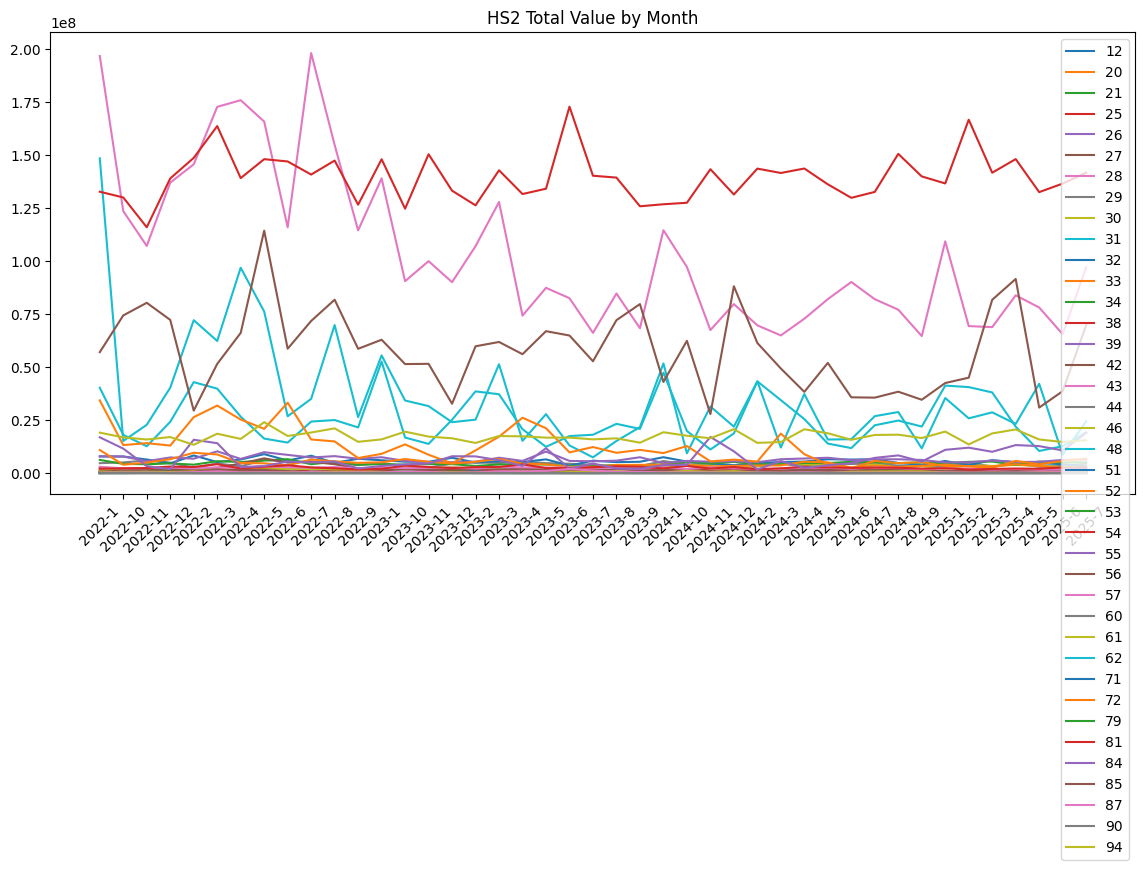

In [47]:
plt.figure(figsize=(14,6))
for c in pivot_hs2.columns:
    plt.plot(pivot_hs2.index, pivot_hs2[c], label=c)

plt.legend()
plt.title("HS2 Total Value by Month")
plt.xticks(rotation=45)
plt.show()

In [49]:
def lag_corr(df, lag=1):
    cols = df.columns
    results = []

    for a in cols:
        for b in cols:
            if a == b:
                continue
            x = df[a].shift(lag)
            y = df[b]
            corr = np.corrcoef(x.iloc[lag:], y.iloc[lag:])[0, 1]
            results.append([a, b, lag, corr])

    return pd.DataFrame(results, columns=["lead_hs2", "follow_hs2", "lag", "corr"])

lag_all_hs2 = []
for L in range(1,4):
    lag_all_hs2.append(lag_corr(pivot_hs2, lag=L))

lag_corr_hs2 = pd.concat(lag_all_hs2).sort_values("corr", ascending=False)
lag_corr_hs2.head(20)


,lead_hs2,follow_hs2,lag,corr
1193,72,42,2,0.710110
56,20,48,1,0.704202
1438,90,79,1,0.695756
1193,72,42,1,0.692615
242,28,42,1,0.690184
866,53,72,3,0.655908
1184,72,28,1,0.651361
1144,71,26,1,0.647339
1042,60,43,3,0.639621
819,52,53,3,0.637906


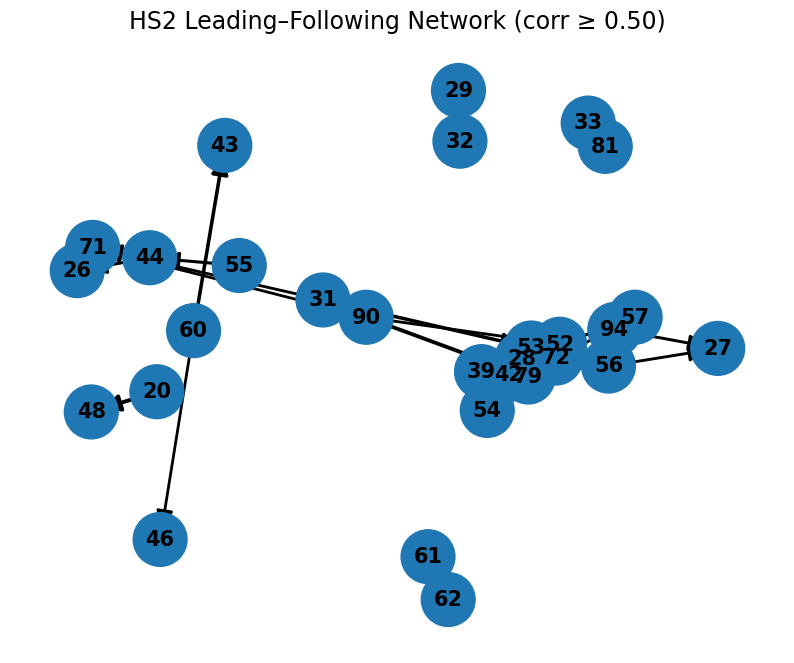

In [50]:
strong_hs2 = lag_corr_hs2[lag_corr_hs2["corr"] >= 0.50]

G = nx.DiGraph()

# Node 색상 (HS2는 cluster가 없음 → 그냥 파랑)
for hs2 in strong_hs2["lead_hs2"].unique():
    G.add_node(hs2, color="#1f77b4")

for hs2 in strong_hs2["follow_hs2"].unique():
    G.add_node(hs2, color="#1f77b4")

# Edge
for _, row in strong_hs2.iterrows():
    G.add_edge(row["lead_hs2"], row["follow_hs2"], weight=row["corr"])

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(10,8))
node_colors = [G.nodes[n]["color"] for n in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1500)
weights = [G[u][v]['weight'] * 4 for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=weights, arrowsize=25)
nx.draw_networkx_labels(G, pos, font_size=15, font_weight='bold')

plt.title("HS2 Leading–Following Network (corr ≥ 0.50)", fontsize=17)
plt.axis("off")
plt.show()

In [52]:
monthly["hs3"] = monthly["hs4"].astype(str).str[:3]
monthly["ym"] = monthly["year"].astype(str) + "-" + monthly["month"].astype(str)


In [53]:
pivot_hs3 = monthly.pivot_table(
    index="ym",
    columns="hs3",
    values="total_value",
    aggfunc="sum"
).fillna(0)

pivot_hs3 = pivot_hs3.sort_index()
pivot_hs3


hs3,121,200,210,250,252,261,270,271,280,281,...,790,810,846,847,850,852,870,871,902,940
ym,,,,,,,,,,,,,,,,,,,,,
2022-1,471191.0,267743.0,242705.0,108699.0,1179252.0,0.0,0.0,0.0,1712098.0,168721512.0,...,571.0,2050641.0,375148.0,16488096.0,56825682.0,230828.0,7718.0,177783.0,0.0,19061787.0
2022-10,818048.0,167163.0,89292.0,60533.0,846360.0,0.0,3849.0,0.0,361661.0,106285724.0,...,0.0,2230204.0,27619.0,11505150.0,74266274.0,131112.0,89758.0,167609.0,128334.0,16844753.0
2022-11,416609.0,165669.0,141264.0,201344.0,343094.0,0.0,8900.0,0.0,983685.0,80278406.0,...,64073.0,2353949.0,300747.0,2960961.0,80310716.0,37050.0,55562.0,158411.0,20404.0,15840634.0
2022-12,480553.0,430356.0,71149.0,95875.0,2388068.0,0.0,11.0,0.0,1202155.0,104825564.0,...,26260.0,3073176.0,118677.0,1735979.0,72114336.0,157217.0,78405.0,77543.0,0.0,16987005.0
2022-2,497978.0,312664.0,120847.0,78853.0,1715532.0,0.0,88.0,1080.0,437766.0,121893065.0,...,32.0,2868542.0,59900.0,15648728.0,29377273.0,77269.0,24829.0,414114.0,891.0,13335477.0
2022-3,389339.0,328915.0,197317.0,172237.0,1951128.0,0.0,0.0,347.0,913525.0,138188763.0,...,0.0,4157619.0,57350.0,14038395.0,51339283.0,184998.0,102019.0,727130.0,0.0,18560854.0
2022-4,741965.0,268882.0,126142.0,89681.0,885208.0,0.0,0.0,0.0,653380.0,142035042.0,...,0.0,2148145.0,594407.0,2193465.0,66035411.0,106294.0,33215.0,317963.0,0.0,16122526.0
2022-5,719907.0,278877.0,71730.0,81387.0,1960421.0,0.0,134.0,0.0,521144.0,135127466.0,...,2675.0,2939365.0,649685.0,2631812.0,114103240.0,290481.0,82348.0,323960.0,23141.0,24022532.0
2022-6,315288.0,324921.0,149138.0,164749.0,2076080.0,0.0,52.0,0.0,1368213.0,80872771.0,...,117.0,3677548.0,520955.0,4926481.0,58500572.0,167475.0,42138.0,228633.0,13258.0,17499684.0


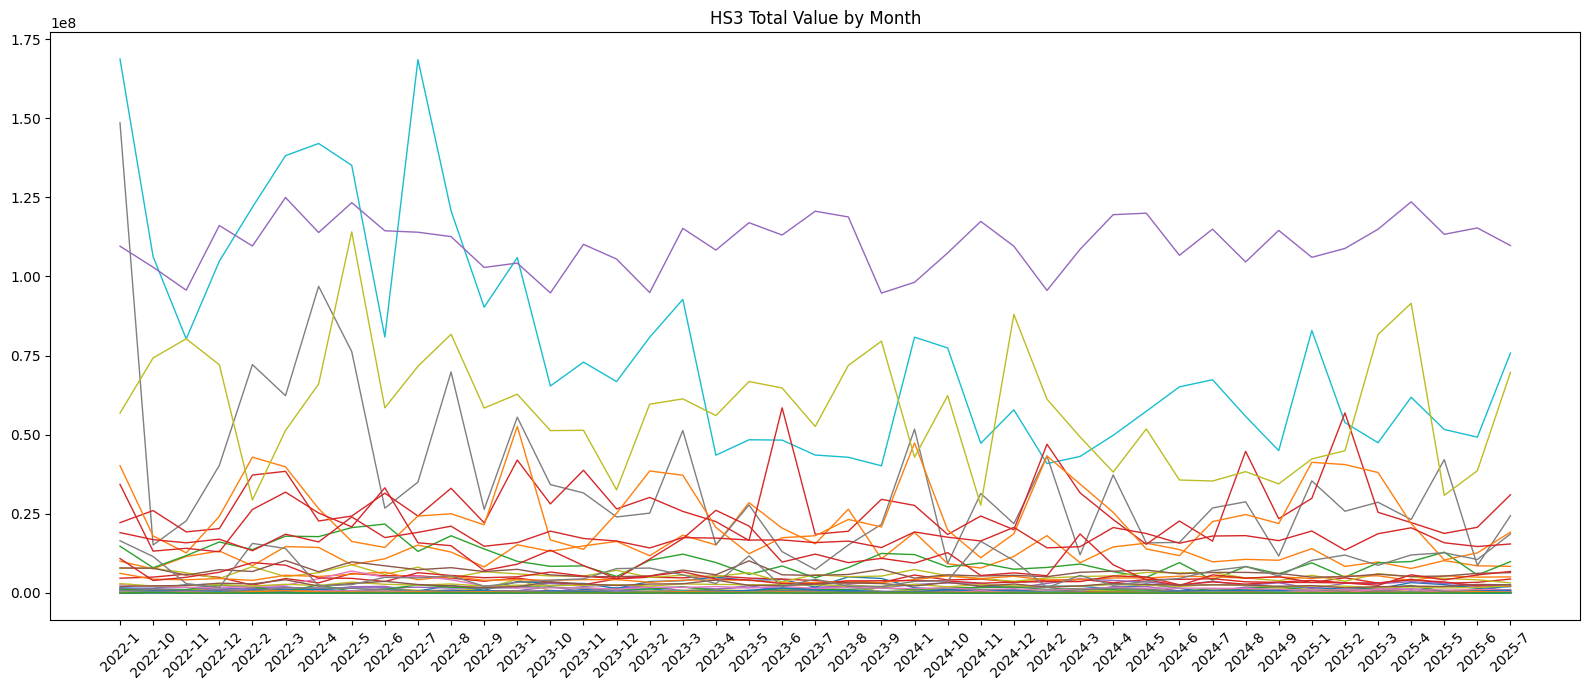

In [54]:
plt.figure(figsize=(16,7))

for col in pivot_hs3.columns:
    plt.plot(pivot_hs3.index, pivot_hs3[col], lw=1)

plt.title("HS3 Total Value by Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [56]:
def lag_corr(df, lag=1):
    cols = df.columns
    results = []

    for a in cols:
        for b in cols:
            if a == b:
                continue
            x = df[a].shift(lag)
            y = df[b]
            corr = np.corrcoef(x.iloc[lag:], y.iloc[lag:])[0, 1]
            results.append([a, b, lag, corr])

    return pd.DataFrame(results, columns=["lead_hs3", "follow_hs3", "lag", "corr"])

lag_all_hs3 = []

for L in range(1, 7):
    lag_df = lag_corr(pivot_hs3, lag=L)
    lag_all_hs3.append(lag_df)

lag_corr_hs3 = pd.concat(lag_all_hs3).sort_values("corr", ascending=False)
lag_corr_hs3.head(20)


,lead_hs3,follow_hs3,lag,corr
2763,902,271,3,0.860852
1472,430,714,6,0.817126
1499,440,302,4,0.782976
1491,440,271,6,0.777755
438,280,302,6,0.758166
2729,871,420,2,0.731570
1844,530,720,5,0.727390
661,284,420,1,0.721814
1411,420,530,6,0.716647
645,284,281,1,0.715371


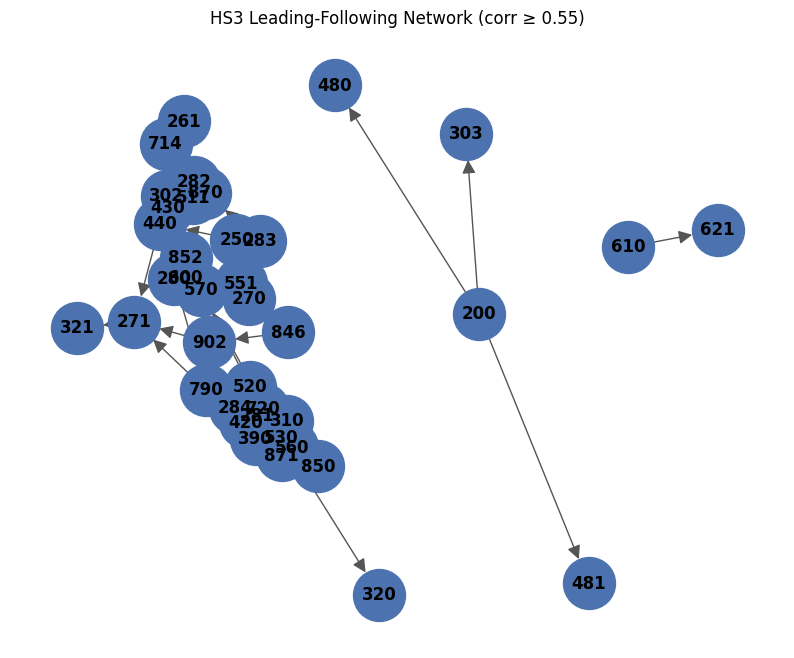

In [57]:
strong_hs3 = lag_corr_hs3[lag_corr_hs3["corr"] >= 0.55]

G = nx.DiGraph()
for _, row in strong_hs3.iterrows():
    G.add_edge(row["lead_hs3"], row["follow_hs3"], weight=row["corr"])

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(10,8))
nx.draw_networkx(
    G, pos,
    node_color="#4c72b0",
    node_size=1400,
    arrowsize=20,
    font_size=12,
    font_weight="bold",
    edge_color="#555"
)
plt.title("HS3 Leading-Following Network (corr ≥ 0.55)")
plt.axis("off")
plt.show()
